In [2]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: AlexNet
# Author: Tracy Tao
# Date: 2022/04/11
import torch 
from torch import nn
from d2l import torch as d2l

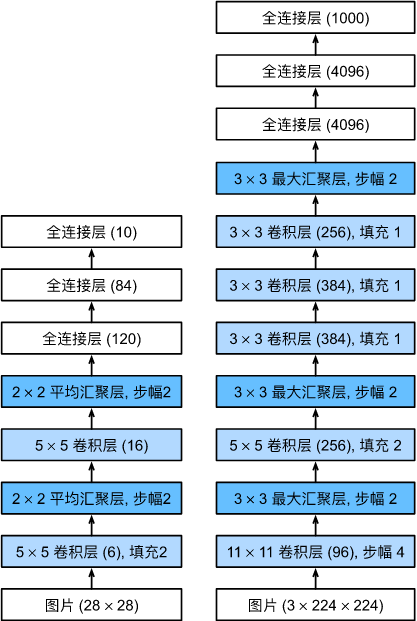
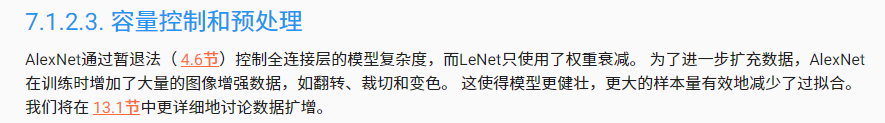

In [13]:
batch_size = 128
lr, num_epochs = 0.01, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super(AlexNet, self).__init__()
        self.features == nn.Sequential(nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding =2),nn.ReLU(inplace=True),
                                       nn.MaxPool2d(kernel_size = 3, stride = 2),
                                       nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(inplace=True),
                                       nn.MaxPool2d(kernel_size=3, stride=2),
                                       nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
                                       nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
                                       nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
                                       nn.MaxPool2d(kernel_size=3, stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(nn.Dropout(), nn.Linear(256 * 6 * 6, 4096), nn.ReLU(inplace=True),
            nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes))
        if init_weights:
            self._initialize_weights()
    
    def forward(self, X):
        X = self.features(X)
        X = torch.flatten(X, start_dim = 1) # 展平
        X = self.classifier(X)
        return X                              
    
    def _initial_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                elif isintance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01) # 正态分布赋值
                    nn.init.constant_(m.bias, 0)

In [25]:
net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [29]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # 训练损失之和，训练准确率之和，样本数
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # 下面是与“d2l.train_epoch_ch3”的主要不同
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [30]:
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cpu')